<style>
/* Set font size for headers */
h1, h2, h3, h4, h5, h6 {
    font-size: 32px; /* Adjust as needed */
}

/* Set font size for paragraphs */
p, li, ul {
    font-size: 24px; /* Adjust as needed */
}
</style>


Introduction to the Julia programming language

![](images/julia-logo.svg)

## 19 Machine learning

## Types of Machine Learning

![](images/types_of_machine_learning.png)

## Supervised learning

![](images/supervised_learning.png)

Popular Machine Learning Packages in Julia:

**Flux.jl** (Deep learning, flexible):

* Powerful and flexible framework for building and training various neural network architectures.
* Offers automatic differentiation for efficient gradient calculations.
* Similar to PyTorch in functionality and community, but with a more concise syntax.

**MLJ.jl** (General-purpose, user-friendly):

* General-purpose machine learning library with familiar algorithms for classification, regression, and dimensionality reduction.
* Provides a user-friendly interface with clear documentation.
* Similar to scikit-learn in offering established algorithms and a user-friendly API, but with a focus on Julia's performance.

## XGBoost

* XGBoost (eXtreme Gradient Boosting) is a powerful machine learning algorithm excelling for **regression** and **cassification**
* It's particularly well-suited for handling tabular data
* XGBoost is known for accuracy, efficiency, and scalability to large datasets
* XGBoost uses gradient boosting to combine weak decision trees into a strong learner.
* Julia users can leverage XGBoost through the XGBoost.jl package, providing a convenient interface to this powerful algorithm within the Julia ecosystem.

We use the simulated data from the [MAGIC telescope](https://en.wikipedia.org/wiki/MAGIC_(telescope).

The MAGIC telescope is a Cherenkov telescope situated on La Palma, one of the Canary Islands. The [MAGIC machine learning dataset](https://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope) can be obtained from [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

Our task is to separate signal events (gamma showers) and background events (hadron showers) based on the features of a measured Cherenkov shower.

## Classification of air showers
![](images/magic_overview.png)

## Features of the measured air showers
![](images/magic_variables.png)



The features of a shower are:

    1.  fLength:  continuous  # major axis of ellipse [mm]
    2.  fWidth:   continuous  # minor axis of ellipse [mm] 
    3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
    4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
    5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
    6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
    7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
    8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
    9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
    10. fDist:    continuous  # distance from origin to center of ellipse [mm]
    11. class:    g,h         # gamma (signal), hadron (background)

g = gamma (signal):     12332
h = hadron (background): 6688

For technical reasons, the number of h events is underestimated.
In the real data, the h class represents the majority of the events.

In [1]:
using CSV, DataFrames, XGBoost, MLUtils, Plots
ENV["DATAFRAMES_ROWS"] = 10;

In [2]:
magic_data = CSV.read(joinpath("data", "magic04_data.txt"), DataFrame)
magic_data.class = (l -> l == "g" ? 1 : 0).(magic_data.class)
magic_data

Row,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.011,-8.2027,40.092,81.8828,1
2,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.261,1
3,162.052,136.031,4.0612,0.0374,0.0187,116.741,-64.858,-45.216,76.96,256.788,1
4,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.449,116.737,1
5,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.648,356.462,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
19016,21.3846,10.917,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.826,0
19017,28.9452,6.702,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.456,0
19018,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.517,0


In [3]:
# y = value to predict, X = features
# Convert DataFrame to tuple of arrays
X = Matrix(magic_data[:, 1:end-1])  # Features
y = magic_data[:, :class];          # Target

In [4]:
# Shuffle observations
shuffled_indices = shuffleobs(1:size(X, 1))  # Shuffle row indices
X_shuffled = X[shuffled_indices, :]
y_shuffled = y[shuffled_indices, :];

In [5]:
# Split shuffled data into training and test sets, 
# 80% training, 20% testing
train_indices, test_indices = splitobs(1:size(X, 1), at = 0.8)  

train_X = X_shuffled[train_indices, :]
train_y = vec(y_shuffled[train_indices, :])
test_X = X_shuffled[test_indices, :]
test_y = vec(y_shuffled[test_indices, :]);

In [6]:
bst = xgboost((train_X, train_y), num_round=1000, objective="binary:logistic")

┌ Info: XGBoost: starting training.
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:601
┌ Info: [1]	train-logloss:0.51961751233641407
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [2]	train-logloss:0.44760091668024238
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [3]	train-logloss:0.40027777335021869
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [4]	train-logloss:0.36961938653603493
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [5]	train-logloss:0.34615575183637354
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [6]	train-logloss:0.32903825727435365
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [7]	train-logloss:0.31338244138606730
└ @ XGBoost /Users/reygers/.julia/packages/XGBoost/nqMqQ/src/booster.jl:451
┌ Info: [8]	train-logloss:0.301292

Booster()

Evaluate model on test data

In [7]:
predictions = predict(bst, test_X);

Plot predicted probabilities for the test sample for signal and background events:

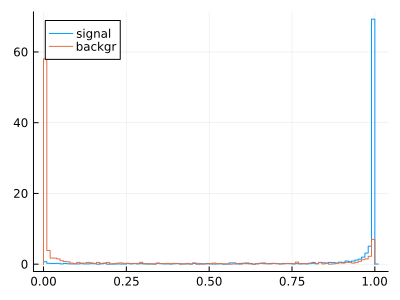

In [8]:
signal_indicees = findall(test_y .== 1);
backgr_indecees = findall(test_y .!= 1);

stephist(predictions[signal_indicees], normalize=true, label="signal", bins=100, size=(400,300))
stephist!(predictions[backgr_indecees], normalize=true, label="backgr", bins=100)

Accuracy (fraction of correctly classified instances):

In [9]:
# Calculate evaluation metric (e.g., accuracy)
threshold = 0.8
predicted_labels = Int64.(predictions .> threshold)
acc = sum(predicted_labels .== test_y) / length(test_y)
println("accuracy = $(acc)")

accuracy = 0.867770767613039


## MNIST classification using Flux

![](images/MnistExamplesModified.png)

See here for more information on the [https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database).

## Convolutional Neural Networks (CNNs)

![](images/cnn-overview.png)

## Layers of a CNN

![](images/cnn-layers.png)

The following code is from the course [Julia for Optimization and Learning](https://juliateachingctu.github.io/Julia-for-Optimization-and-Learning/stable/lecture_11/nn/).

In [21]:
using MLDatasets

T = Float32
X_train, y_train = MLDatasets.MNIST(T, :train)[:]
X_test, y_test = MLDatasets.MNIST(T, :test)[:];

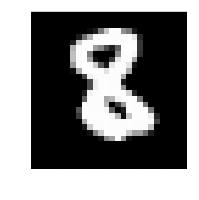

In [22]:
using Plots

# Choose some random indices to plot
indices_to_plot = rand(1:size(X_train)[3])
heatmap(X_train[:, :, indices_to_plot]', color=:grays, axis=false, c=:greys, legend=false, size=(200, 200))

In [12]:
function reshape_data(X::AbstractArray{<:Real, 3})
    s = size(X)
    return reshape(X, s[1], s[2], 1, s[3])
end

reshape_data (generic function with 1 method)

In [13]:
using Flux
using Flux: onehotbatch, onecold

function load_data(dataset; T=Float32, onehot=false, classes=0:9)
    X_train, y_train = dataset(T, :train)[:]
    X_test, y_test = dataset(T, :test)[:]

    X_train = reshape_data(X_train)
    X_test = reshape_data(X_test)

    if onehot
        y_train = onehotbatch(y_train, classes)
        y_test = onehotbatch(y_test, classes)
    end

    return X_train, y_train, X_test, y_test
end

load_data (generic function with 1 method)

In [23]:
X_train, y_train, X_test, y_test = 
    load_data(MLDatasets.MNIST; T=T, onehot=true);

In [15]:
using Random
using Flux: flatten

Random.seed!(31)
m = Chain(
    Conv((2,2), 1=>16, relu),
    MaxPool((2,2)),
    Conv((2,2), 16=>8, relu),
    MaxPool((2,2)),
    flatten,
    Dense(288, size(y_train,1)),
    softmax,
)

Chain(
  Conv((2, 2), 1 => 16, relu),          # 80 parameters
  MaxPool((2, 2)),
  Conv((2, 2), 16 => 8, relu),          # 520 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(288 => 10),                     # 2_890 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 3_490 parameters, 14.711 KiB.

Define the loss function

In [16]:
using Flux: crossentropy

L(X, y) = crossentropy(m(X), y)

L (generic function with 1 method)

In [17]:
using Flux.Data: DataLoader

batchsize = 32
batches = DataLoader((X_train, y_train); batchsize, shuffle = true)

1875-element DataLoader(::Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=32)
  with first element:
  (28×28×1×32 Array{Float32, 4}, 10×32 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [18]:
using BSON
using Flux: params

function train_model!(m, L, X, y;
        opt = Descent(0.1),
        batchsize = 128,
        n_epochs = 10,
        file_name = "")

    batches = DataLoader((X, y); batchsize, shuffle = true)

    for _ in 1:n_epochs
        Flux.train!(L, params(m), batches, opt)
    end

    !isempty(file_name) && BSON.bson(file_name, m=m)

    return
end

train_model! (generic function with 1 method)

In [19]:
file_name = "mnist_simple.bson"
train_model!(m, L, X_train, y_train; n_epochs=10, file_name=file_name)

In [20]:
using Statistics

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

"Test accuracy = " * string(accuracy(X_test, y_test))

"Test accuracy = 0.9753"